# Chalenge Pneumonia

In [ ]:
# !pip install tensorflow-gpu
# !pip install keras
# !pip install opencv-python
# !pip install tqdm

In [1]:
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, AlphaDropout, Input, GaussianNoise, BatchNormalization
from keras.models import Sequential, Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import applications
from keras import backend as K
from keras.preprocessing import image
from keras.utils import multi_gpu_model

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

import numpy as np

from tqdm import tqdm
import itertools
import os
import random as rn

import skimage
from skimage.transform import resize
from skimage import exposure

import cv2

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/weryquessantos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seed = 7
tf.set_random_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(seed)

!nvidia-smi

Mon Jun 11 15:56:51 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    26W / 149W |     16MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:05.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Imports data from kaggle

In [ ]:
!pip install msgpack
!pip install kaggle

In [ ]:
!ls -al

In [ ]:
!mkdir /home/weryquessantos/.kaggle

!echo '{"username":"","key":""}' > /home/weryquessantos/.kaggle/kaggle.json
!chmod 600 /home/weryquessantos/.kaggle/kaggle.json
!cat /home/weryquessantos/.kaggle/kaggle.json

In [ ]:
!kaggle datasets files -d paultimothymooney/chest-xray-pneumonia

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!ls /home/weryquessantos/.kaggle/datasets/paultimothymooney/chest-xray-pneumonia/

In [ ]:
!unzip /home/weryquessantos/.kaggle/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray.zip

In [ ]:
!ls

### Load data

In [3]:
train_dir = "./chest_xray/train/"
test_dir =  "./chest_xray/test/"
val_dir = "./chest_xray/val/"

def load_data(folders):
    X = []
    Y = []
    
    for folder in folders:
        for folderName in os.listdir(folder):
            if not folderName.startswith('.'):
                print('\n{}{}:'.format(folder, folderName))
                if folderName in ['NORMAL']:
                    label = 0
                elif folderName in ['PNEUMONIA']:
                    label = 1
                else:
                    print('Deu errado!')
                    label = 2
                for image_filename in tqdm(os.listdir(folder + folderName)):
                    img_file = cv2.imread(folder + folderName + '/' + image_filename)
                    if img_file is not None:
                        img_file = resize(img_file, (224, 224, 3), mode='reflect')
                        img_arr = image.img_to_array(img_file)
                        X.append(img_arr)
                        Y.append(label)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    
    return X, to_categorical(Y)

In [4]:
# Merge val with train
X, Y = load_data([train_dir, val_dir])

  0%|          | 1/1342 [00:00<02:35,  8.61it/s]


./chest_xray/train/NORMAL:


  0%|          | 3/3876 [00:00<02:46, 23.24it/s]


./chest_xray/train/PNEUMONIA:


 11%|█         | 1/9 [00:00<00:00,  9.71it/s]


./chest_xray/val/NORMAL:


 33%|███▎      | 3/9 [00:00<00:00, 17.45it/s]


./chest_xray/val/PNEUMONIA:


100%|██████████| 9/9 [00:00<00:00, 28.03it/s]


In [5]:
# Val now is test
x_val, y_val = load_data([test_dir])

  1%|          | 2/234 [00:00<00:17, 13.62it/s]


./chest_xray/test/NORMAL:


  1%|▏         | 5/390 [00:00<00:09, 41.92it/s]


./chest_xray/test/PNEUMONIA:


100%|██████████| 390/390 [00:11<00:00, 33.84it/s]


In [6]:
print(X.shape, Y.shape, x_val.shape)

(5232, 224, 224, 3) (5232, 2) (624, 224, 224, 3)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = seed, stratify=Y)

In [8]:
print(x_train.shape, x_test.shape)

(4185, 224, 224, 3) (1047, 224, 224, 3)


Pneumonia: [0. 1.]


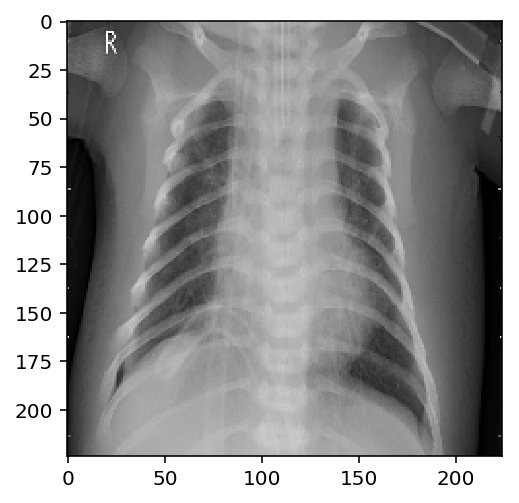

Normal: [1. 0.]


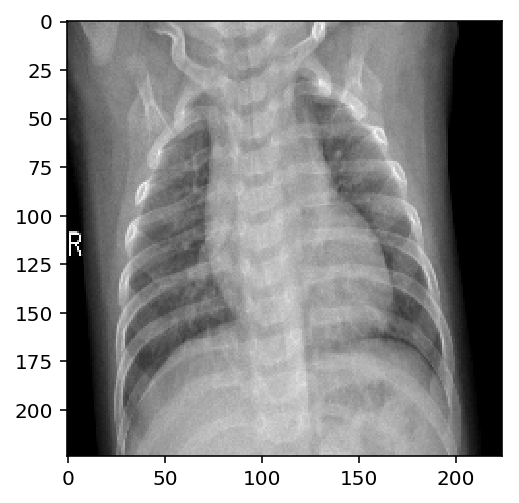

In [9]:
print('Pneumonia:', y_val[500])
plt.imshow(x_val[500][:])
plt.show()

print('Normal:', y_val[8])
plt.imshow(x_val[8][:])
plt.show()

In [10]:
class Metrics(Callback):       
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        
        val_targ = self.validation_data[1]
        
        _val_f1 = f1_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1))
        _val_recall = recall_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1))
        _val_precision = precision_score(np.argmax(val_targ, axis=1), np.argmax(val_predict, axis=1))
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        print("— val_f1: {} — val_precision: {} — val_recall {}".format(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()

def plot_confusion_matrix(model, classes,
                          cmap=plt.cm.Blues):
    
    y_pred = model.predict(x_val, batch_size=8)
        
    _val_f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    _val_recall = recall_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    _val_precision = precision_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
                
    print("\nval_f1: {} | val_precision: {} | val_recall {}\n".format(_val_f1, _val_precision, _val_recall))
    
    plt.figure(figsize = (5,5))

    cm = confusion_matrix(np.argmax(y_val, axis = 1), np.argmax(y_pred, axis = 1))
    
    sns.heatmap(cm, annot = True, fmt = "d", cmap = 'Blues')
    
    plt.title('Confusion Matrix')
    
    tick_marks = np.arange(len(classes)) + 0.5
    
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        
    plt.show()
    
    errors = np.where(np.argmax(y_pred, axis=1) != np.argmax(y_val, axis=1))[0]
    print("No of errors = {}/{}".format(len(errors), len(y_val)))

    # Show the errors
#     for i in range(len(errors)):
#         pred_class = np.argmax(y_pred[errors[i]])

#         title = 'original class: {} | pred class: {} | confidence : {}%'.format(
#             y_val[errors[i]],
#             y_pred[errors[i]],
#             y_pred[errors[i]][pred_class])

#         original = x_val[errors[i]]
#         plt.figure(figsize=[4,4])
#         plt.axis('off')
#         plt.title(title)
#         plt.imshow(original)
#         plt.show()
    
def plot_learning_curve(history, model):
    
    loss, acc = model.evaluate(x_val, y_val, verbose = 1, batch_size=8)
        
    print('\nValidation Dataset: {}: {} | {}: {}%'.format(
        model.metrics_names[0], loss,
        model.metrics_names[1], acc * 100))
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()
    #plt.savefig('./accuracy_curve.png')
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    #plt.savefig('./loss_curve.png')

### Callbacks

In [11]:
checkpoint16 = keras.callbacks.ModelCheckpoint('./best_weights16.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

### Data augmentation

In [12]:
datagen16 = image.ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True)

### VGG16

In [21]:
modelVGG16 = applications.VGG16(weights='imagenet', include_top=False, input_shape=x_train[0].shape)

vgg_out16 = modelVGG16.output

# for layer in modelVGG16.layers[:]:
#     layer.trainable = False

# flatten
x16 = Flatten()(vgg_out16)

x16 = Dense(32, activation = 'relu', kernel_initializer='lecun_normal', bias_initializer='ones')(x16)
x16 = Dropout(0.01)(x16)

x16 = Dense(16, activation = 'relu', kernel_initializer='lecun_normal', bias_initializer='ones')(x16)
x16 = Dropout(0.01)(x16)

prediction16 = Dense(2, activation = 'softmax', kernel_initializer='lecun_normal', bias_initializer='ones')(x16)

modelVGG2 = Model(inputs=modelVGG16.input, outputs=prediction16)
modelVGG2Parallel = multi_gpu_model(modelVGG2, gpus=2)

In [14]:
modelVGG2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [22]:
#lr = 0.01
#decay = 1e-9
#momentum = 1e-8

sgd2 = keras.optimizers.SGD(lr=0.01, decay = 0.0, momentum=1e-8)

modelVGG2.compile(loss='categorical_crossentropy',
              optimizer=sgd2,
              metrics=['accuracy'])

In [23]:
# fits the model on batches with real-time data augmentation:
modelVGG2Parallel.fit_generator(datagen16.flow(x_train, y_train, batch_size=8), 
                                    steps_per_epoch=len(x_train) / 8, epochs=30,
                                    validation_data=(x_test, y_test),
                                    callbacks=[metrics, checkpoint16, early_stopping])

Epoch 1/30
524/523 [==============================] - 142s 272ms/step - loss: 0.3697 - acc: 0.8337 - val_loss: 0.2459 - val_acc: 0.8806
— val_f1: 0.9132546842470506 — val_precision: 0.9909638554216867 — val_recall 0.8468468468468469
Epoch 2/30
524/523 [==============================] - 141s 269ms/step - loss: 0.1917 - acc: 0.9227 - val_loss: 0.1288 - val_acc: 0.9503
— val_f1: 0.9655629139072848 — val_precision: 0.9945429740791268 — val_recall 0.9382239382239382
Epoch 3/30
524/523 [==============================] - 141s 269ms/step - loss: 0.1525 - acc: 0.9437 - val_loss: 0.1016 - val_acc: 0.9647
— val_f1: 0.9759896171317327 — val_precision: 0.9842931937172775 — val_recall 0.9678249678249679
Epoch 4/30
524/523 [==============================] - 141s 270ms/step - loss: 0.1288 - acc: 0.9513 - val_loss: 0.1511 - val_acc: 0.9427
— val_f1: 0.9601063829787234 — val_precision: 0.9931224209078404 — val_recall 0.9292149292149292
Epoch 5/30
524/523 [==============================] - 141s 270ms/ste

624/624 [==============================] - 6s 10ms/step

Validation Dataset: loss: 0.14038591920801152 | acc: 95.51282051282051%


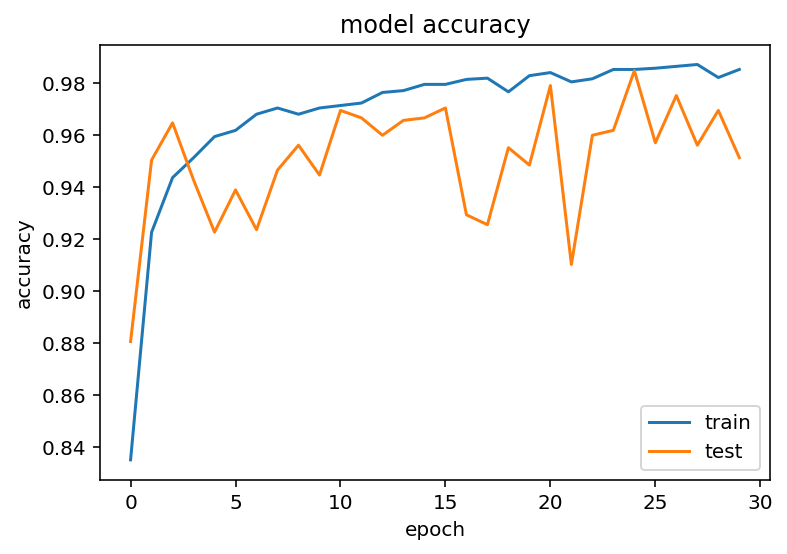

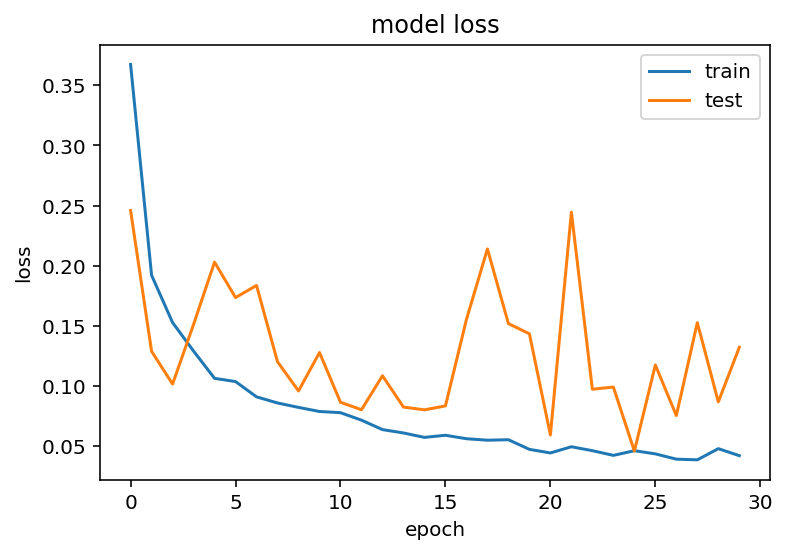

In [38]:
plot_learning_curve(modelVGG2Parallel.history, modelVGG2Parallel)


val_f1: 0.9643765903307888 | val_precision: 0.9570707070707071 | val_recall 0.9717948717948718



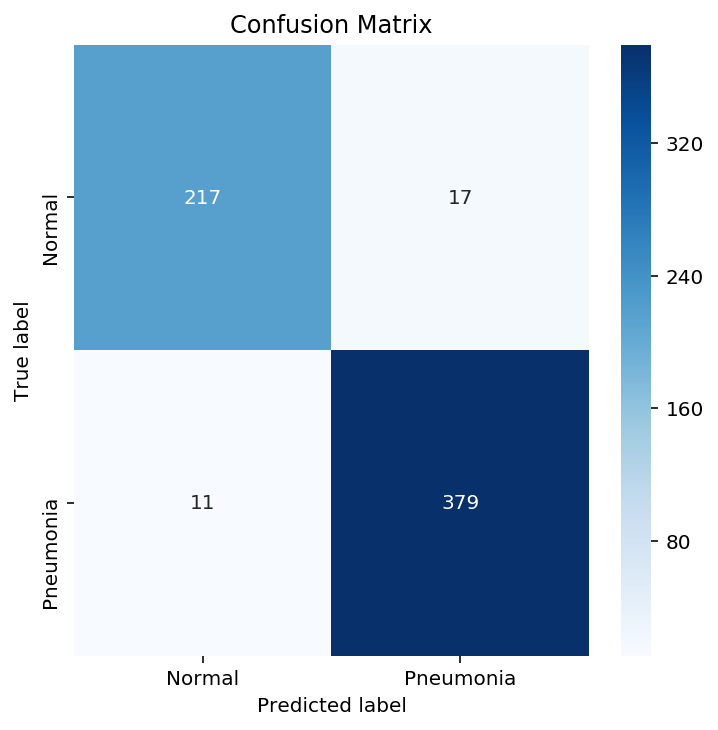

No of errors = 28/624


In [39]:
classes = ['Normal', 'Pneumonia']

plot_confusion_matrix(modelVGG2Parallel, classes)

In [ ]:
#modelVGG2Parallel.save('bestModelVGG16.hdf5')

In [40]:
modelVGG2Parallel.save_weights('bestModelVGG16Weights.hdf5')